In [30]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
import re
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS
import warnings
warnings.filterwarnings("ignore")

In [6]:
file_path = "../data/electrify__applied_ai_engineer__training_data.csv" #loading csv (adjust path if required)
df = pd.read_csv(file_path)
print("Shape:", df.shape)
df.head()
df.info()
df.describe()

Shape: (211, 5)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 211 entries, 0 to 210
Data columns (total 5 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   channel_id       211 non-null    object
 1   video_id         211 non-null    object
 2   title            211 non-null    object
 3   summary          211 non-null    object
 4   views_in_period  211 non-null    int64 
dtypes: int64(1), object(4)
memory usage: 8.4+ KB


,views_in_period
count,211.000000
mean,10436.407583
std,28457.307109
min,21.000000
25%,797.000000
50%,2101.000000
75%,5184.500000
max,336440.000000


In [22]:
# stats per channel
channels = list(df.channel_id.unique())
for i in channels:
    channel_inf = df.loc[df['channel_id'] == i]
    print(channel_inf.describe())
    print()

       views_in_period  title_word_count  title_char_count  summary_word_count
count       107.000000        107.000000        107.000000          107.000000
mean       6149.962617          6.869159         39.551402           38.214953
std       11065.716137          2.176565         11.518020            4.056274
min         193.000000          2.000000         14.000000           28.000000
25%         804.500000          5.000000         32.500000           36.000000
50%        2101.000000          7.000000         39.000000           38.000000
75%        4226.000000          8.000000         46.500000           41.000000
max       59299.000000         14.000000         80.000000           50.000000

       views_in_period  title_word_count  title_char_count  summary_word_count
count         48.00000         48.000000         48.000000           48.000000
mean        5751.18750          4.791667         26.916667           37.750000
std        12704.10797          1.202096          6

In [7]:
# missing values
missing = df.isnull().sum()
print("Missing values per column:\n", missing)

# unique channels and counts of videos per channel
channel_counts = df['channel_id'].value_counts()
print("Videos per channel:\n", channel_counts)

Missing values per column:
 channel_id         0
video_id           0
title              0
summary            0
views_in_period    0
dtype: int64
Videos per channel:
 channel_id
UC510QYlOlKNyhy_zdQxnGYw    107
UC-9b7aDP6ZN0coj9-xFnrtw     56
UC_WXkNIJ2ncLIsAk_ltbvjA     48
Name: count, dtype: int64


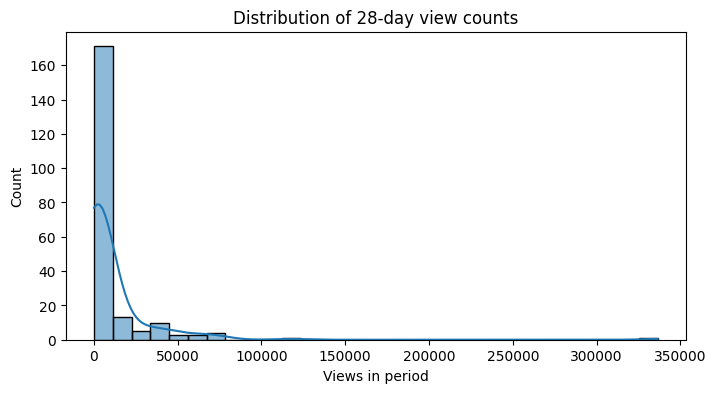

In [8]:
# distribution of views in given period
plt.figure(figsize=(8,4))
sns.histplot(df['views_in_period'], bins=30, kde=True)
plt.title("Distribution of 28‑day view counts")
plt.xlabel("Views in period")
plt.ylabel("Count")
plt.show()

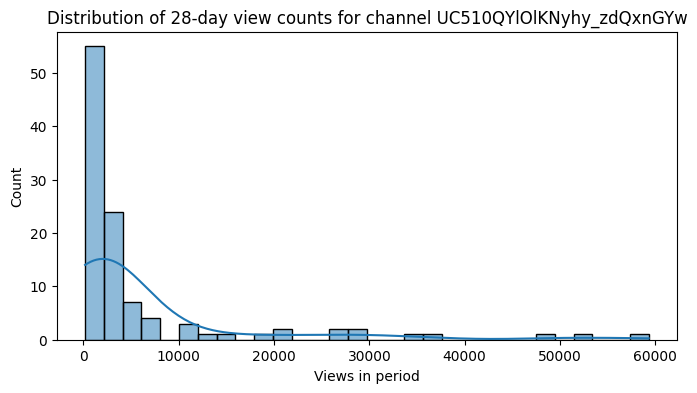

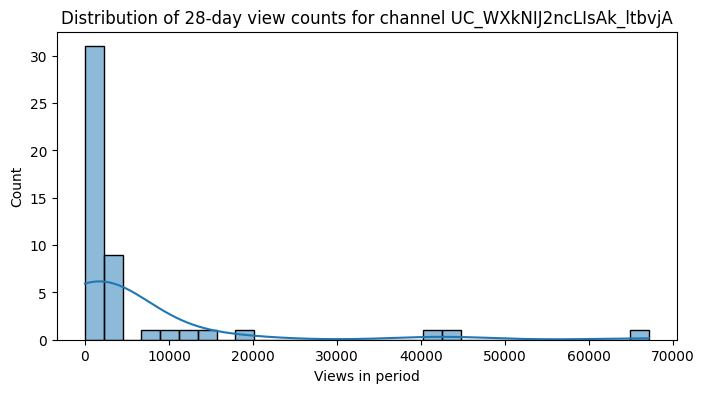

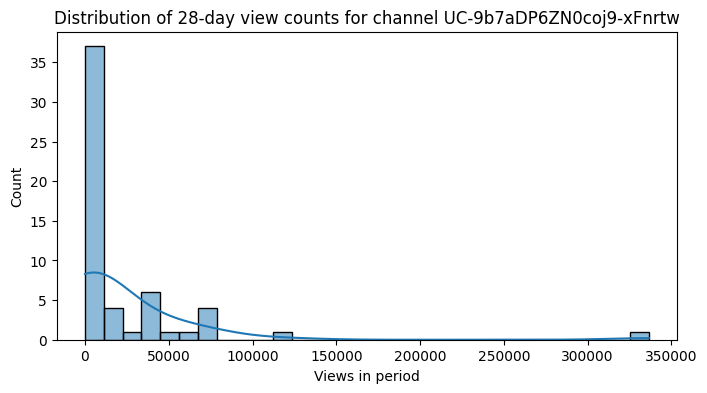

In [33]:
# distribution of views in given period per channel
for i in channels:
    channel_inf = df.loc[df['channel_id'] == i]
    plt.figure(figsize=(8,4))
    sns.histplot(channel_inf['views_in_period'], bins=30, kde=True)
    plt.title(f"Distribution of 28‑day view counts for channel {i}")
    plt.xlabel("Views in period")
    plt.ylabel("Count")
    plt.show()

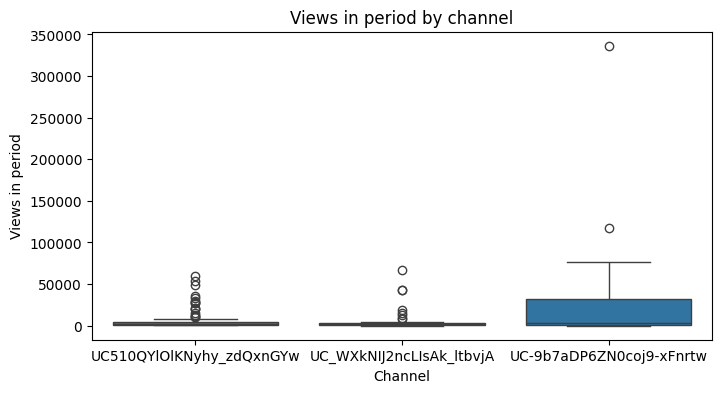

In [9]:
# views by channel
plt.figure(figsize=(8,4))
sns.boxplot(x='channel_id', y='views_in_period', data=df)
plt.title("Views in period by channel")
plt.xlabel("Channel")
plt.ylabel("Views in period")
plt.show()

In [10]:
# title & summary length feats
df['title_word_count'] = df['title'].str.split().apply(len)
df['title_char_count'] = df['title'].str.len()
df['summary_word_count'] = df['summary'].str.split().apply(len)

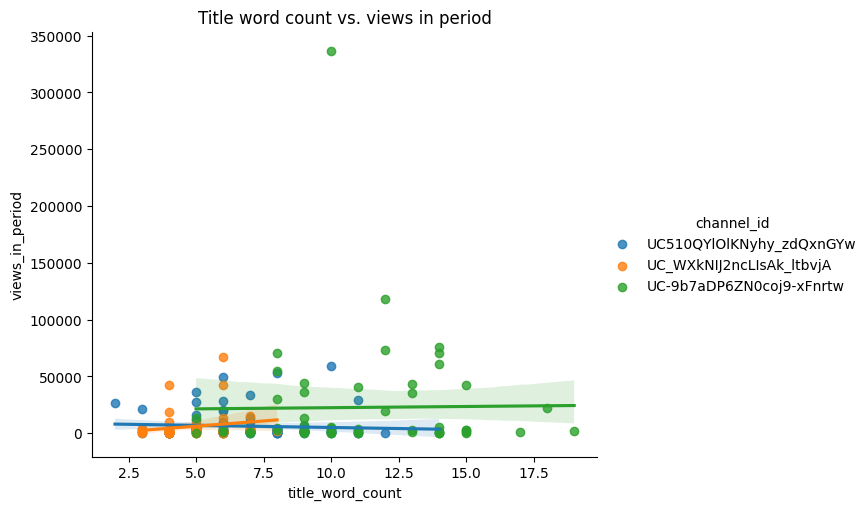

In [11]:
sns.lmplot(x='title_word_count', y='views_in_period', hue='channel_id',
           data=df, height=5, aspect=1.3)
plt.title("Title word count vs. views in period")
plt.show()

In [12]:
# linguistic features in titles
df['has_number'] = df['title'].str.contains(r'\d')
df['has_question'] = df['title'].str.contains(r'\?')
df['has_exclamation'] = df['title'].str.contains(r'!')

In [14]:
pattern_cols = ['has_number', 'has_question', 'has_exclamation']
pattern_summary = df.groupby(pattern_cols)['views_in_period'].mean().reset_index()
print("Average views by title patterns:\n", pattern_summary)

Average views by title patterns:
    has_number  has_question  has_exclamation  views_in_period
0       False         False            False     10910.629630
1       False         False             True      2292.000000
2       False          True            False      9864.307692
3        True         False            False     12440.357143
4        True         False             True      4641.153846
5        True          True            False      2164.500000


In [15]:
# top 25 of views to compare word frequencies
threshold = df['views_in_period'].quantile(0.75)
high_perf = df[df['views_in_period'] >= threshold]
low_perf = df[df['views_in_period'] < threshold]

In [26]:
def tokenize(text):
    return [word.lower().strip(".,!?") for word in text.split()]

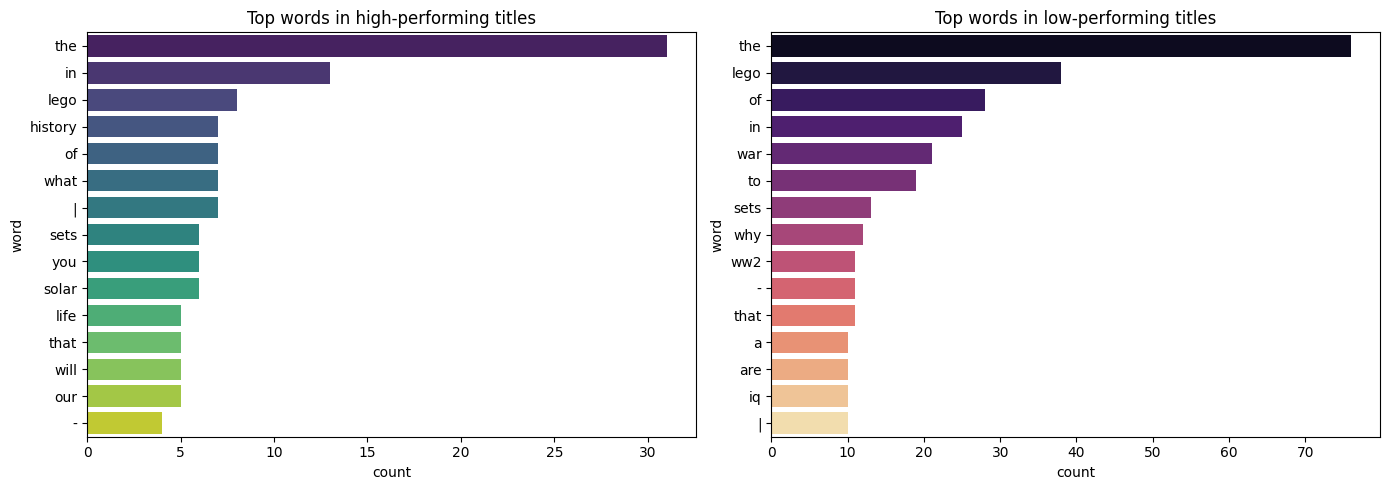

In [27]:
top_n = 15
top_high = high_words.most_common(top_n)
top_low  = low_words.most_common(top_n)

high_df = pd.DataFrame(top_high, columns=['word','count'])
low_df  = pd.DataFrame(top_low,  columns=['word','count'])

fig, axs = plt.subplots(1, 2, figsize=(14, 5))
sns.barplot(ax=axs[0], x='count', y='word', data=high_df, palette='viridis')
axs[0].set_title('Top words in high-performing titles')
sns.barplot(ax=axs[1], x='count', y='word', data=low_df, palette='magma')
axs[1].set_title('Top words in low-performing titles')
plt.tight_layout()
plt.show()

In [31]:
# exclude common words
def tokenize_no_stop(text):
    tokens = re.findall(r"\b\w+\b", str(text).lower())
    return [w for w in tokens if w not in ENGLISH_STOP_WORDS]

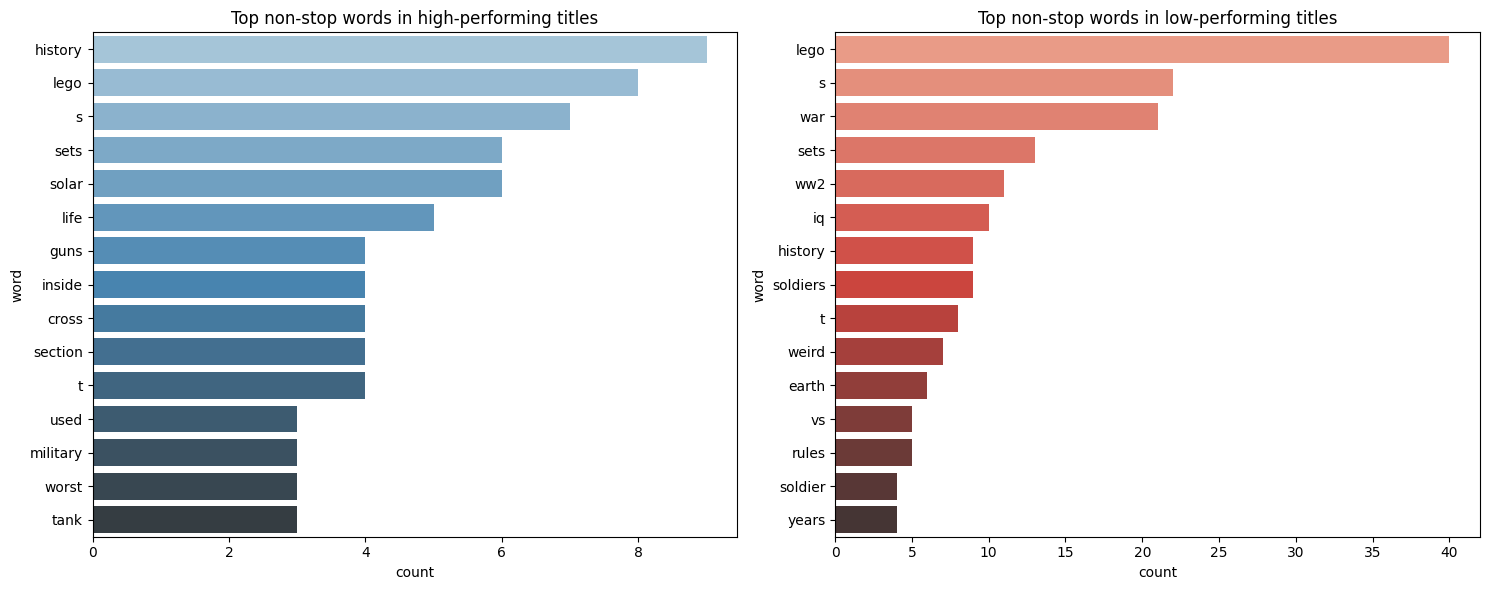

In [32]:
high_words = Counter()
for title in high_perf['title']:
    high_words.update(tokenize_no_stop(title))

low_words = Counter()
for title in low_perf['title']:
    low_words.update(tokenize_no_stop(title))

top_n = 15
high_df = pd.DataFrame(high_words.most_common(top_n), columns=['word','count'])
low_df  = pd.DataFrame(low_words.most_common(top_n),  columns=['word','count'])

fig, axs = plt.subplots(1, 2, figsize=(15, 6))
sns.barplot(ax=axs[0], x='count', y='word', data=high_df, palette='Blues_d')
axs[0].set_title('Top non-stop words in high-performing titles')
sns.barplot(ax=axs[1], x='count', y='word', data=low_df, palette='Reds_d')
axs[1].set_title('Top non-stop words in low-performing titles')
plt.tight_layout()
plt.show()

### Key Findings

- The dataset: data contains 211 videos across three YouTube channels, without any missing values.
- View counts are heavily right-skewed: median approx. 2k, mean around 10k, with max nearing 336k, multiple outliers per channel.
- Comparing Channels: Channel UC-9b7aDP6ZN0coj9-xFnrtw uses longer titles (around 11 words) and has the highest average views (approx. 22k); other channels use shorter titles (averaging between 5–7 words) and lower average views (approx. 5–6k).
- Title length has a weak positive correlation with views: extremely short titles rarely rank among top-performing videos.
- Numeric titles perform best: titles with numbers but no exclamation/question mark average ~12.4k views, while those with questions or exclamations average only ~2.3k–9.8k.
- High-performing titles frequently use specific nouns (e.g. “history”, “solar”, “inside”, “guns”), whereas low-performing titles often include words like “war”, “weird” or “WW2”.